## This notebook performs the Ensemble Ranking.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w
import joblib, csv, os, sys, time
from category_encoders import BinaryEncoder
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, f_regression, f_classif, SelectKBest, chi2, RFECV, mutual_info_classif
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, LogisticRegression, ElasticNet)
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.exceptions import ConvergenceWarning

In [2]:
# Get rid of warnings.
w.filterwarnings('ignore', category=DeprecationWarning)
w.filterwarnings("ignore", category=FutureWarning)
w.filterwarnings("ignore", category=UserWarning, module="seaborn")

In [3]:
# Load the training and test data.
df = pd.read_csv('../data/X_train_id.csv', low_memory=False)
test = pd.read_csv('../data/X_test_id.csv', low_memory=False)

# Load the labels.
y_train = pd.read_csv('../data/y_train_id.csv', low_memory=False)
y_test = pd.read_csv('../data/y_test_id.csv', low_memory=False)

columns = df.columns.tolist()
print(columns)
print(len(columns))

['ID', 'IMPACT', 'BIOTYPE', 'CADD_raw', 'BLOSUM62', 'Conservation', 'ProteinLengthChange', 'MaxEntScan_alt', 'MaxEntScan_diff', 'MaxEntScan_ref', 'TSSDistance', 'ada_score', 'rf_score', '1000Gp3_AF', 'FATHMM_score', 'GERPplus_plus_NR', 'GERPplus_plus_RS', 'GM12878_fitCons_score', 'GenoCanyon_score', 'H1_hESC_fitCons_score', 'HUVEC_fitCons_score', 'LINSIGHT', 'LIST_S2_score', 'LRT_score', 'M_CAP_score', 'MPC_score', 'MVP_score', 'MutationAssessor_score', 'MutationTaster_score', 'PROVEAN_score', 'SiPhy_29way_logOdds', 'UK10K_AF', 'VEST4_score', 'fathmm_MKL_coding_score', 'fathmm_XF_coding_score', 'gnomAD_exomes_AF', 'gnomAD_genomes_AF', 'integrated_fitCons_score', 'phastCons100way_vertebrate', 'phastCons17way_primate', 'phastCons30way_mammalian', 'phyloP100way_vertebrate', 'phyloP17way_primate', 'phyloP30way_mammalian', 'NMD', 'GDI', 'MSC_95CI', 'rel_cDNA_pos', 'rel_CDS_pos', 'rel_prot_pos', 'Selective_pressure', 'Clarks_distance', 'CDS_len', 'Number_of_paralogs', 'denovo_Zscore', 'RVIS'

In [4]:
# Drop the `Protein_dom` column, which is derived from Pfam and/or Interpro.
df_no_pfam = df.drop(columns=['Protein_dom'])
test_no_pfam = test.drop(columns=['Protein_dom'])
original_columns = df_no_pfam.columns.tolist()
print(len(original_columns))
print(original_columns)
test_columns = test_no_pfam.columns.tolist()
print(len(test_columns))
print(test_columns)

500
['ID', 'IMPACT', 'BIOTYPE', 'CADD_raw', 'BLOSUM62', 'Conservation', 'ProteinLengthChange', 'MaxEntScan_alt', 'MaxEntScan_diff', 'MaxEntScan_ref', 'TSSDistance', 'ada_score', 'rf_score', '1000Gp3_AF', 'FATHMM_score', 'GERPplus_plus_NR', 'GERPplus_plus_RS', 'GM12878_fitCons_score', 'GenoCanyon_score', 'H1_hESC_fitCons_score', 'HUVEC_fitCons_score', 'LINSIGHT', 'LIST_S2_score', 'LRT_score', 'M_CAP_score', 'MPC_score', 'MVP_score', 'MutationAssessor_score', 'MutationTaster_score', 'PROVEAN_score', 'SiPhy_29way_logOdds', 'UK10K_AF', 'VEST4_score', 'fathmm_MKL_coding_score', 'fathmm_XF_coding_score', 'gnomAD_exomes_AF', 'gnomAD_genomes_AF', 'integrated_fitCons_score', 'phastCons100way_vertebrate', 'phastCons17way_primate', 'phastCons30way_mammalian', 'phyloP100way_vertebrate', 'phyloP17way_primate', 'phyloP30way_mammalian', 'NMD', 'GDI', 'MSC_95CI', 'rel_cDNA_pos', 'rel_CDS_pos', 'rel_prot_pos', 'Selective_pressure', 'Clarks_distance', 'CDS_len', 'Number_of_paralogs', 'denovo_Zscore', 'R

In [5]:
df_no_pfam.to_csv('../data/X_train_499.csv', index=False)
test_no_pfam.to_csv('../data/X_test_499.csv', index=False)

In [5]:
# Load the updata datasets.
df = pd.read_csv('../data/X_train_499.csv', low_memory=False)
test = pd.read_csv('../data/X_test_499.csv', low_memory=False)
y_train = pd.read_csv('../data/y_train_id.csv', low_memory=False)
y_test = pd.read_csv('../data/y_test_id.csv', low_memory=False)

# Verify shapes (should be 500 instead of 501).
columns = df.columns.tolist()
print(columns)
print(len(columns))
t_columns = test.columns.tolist()
print(t_columns)
print(len(t_columns))

['ID', 'IMPACT', 'BIOTYPE', 'CADD_raw', 'BLOSUM62', 'Conservation', 'ProteinLengthChange', 'MaxEntScan_alt', 'MaxEntScan_diff', 'MaxEntScan_ref', 'TSSDistance', 'ada_score', 'rf_score', '1000Gp3_AF', 'FATHMM_score', 'GERPplus_plus_NR', 'GERPplus_plus_RS', 'GM12878_fitCons_score', 'GenoCanyon_score', 'H1_hESC_fitCons_score', 'HUVEC_fitCons_score', 'LINSIGHT', 'LIST_S2_score', 'LRT_score', 'M_CAP_score', 'MPC_score', 'MVP_score', 'MutationAssessor_score', 'MutationTaster_score', 'PROVEAN_score', 'SiPhy_29way_logOdds', 'UK10K_AF', 'VEST4_score', 'fathmm_MKL_coding_score', 'fathmm_XF_coding_score', 'gnomAD_exomes_AF', 'gnomAD_genomes_AF', 'integrated_fitCons_score', 'phastCons100way_vertebrate', 'phastCons17way_primate', 'phastCons30way_mammalian', 'phyloP100way_vertebrate', 'phyloP17way_primate', 'phyloP30way_mammalian', 'NMD', 'GDI', 'MSC_95CI', 'rel_cDNA_pos', 'rel_CDS_pos', 'rel_prot_pos', 'Selective_pressure', 'Clarks_distance', 'CDS_len', 'Number_of_paralogs', 'denovo_Zscore', 'RVIS'

## Visualizing NaN counts.

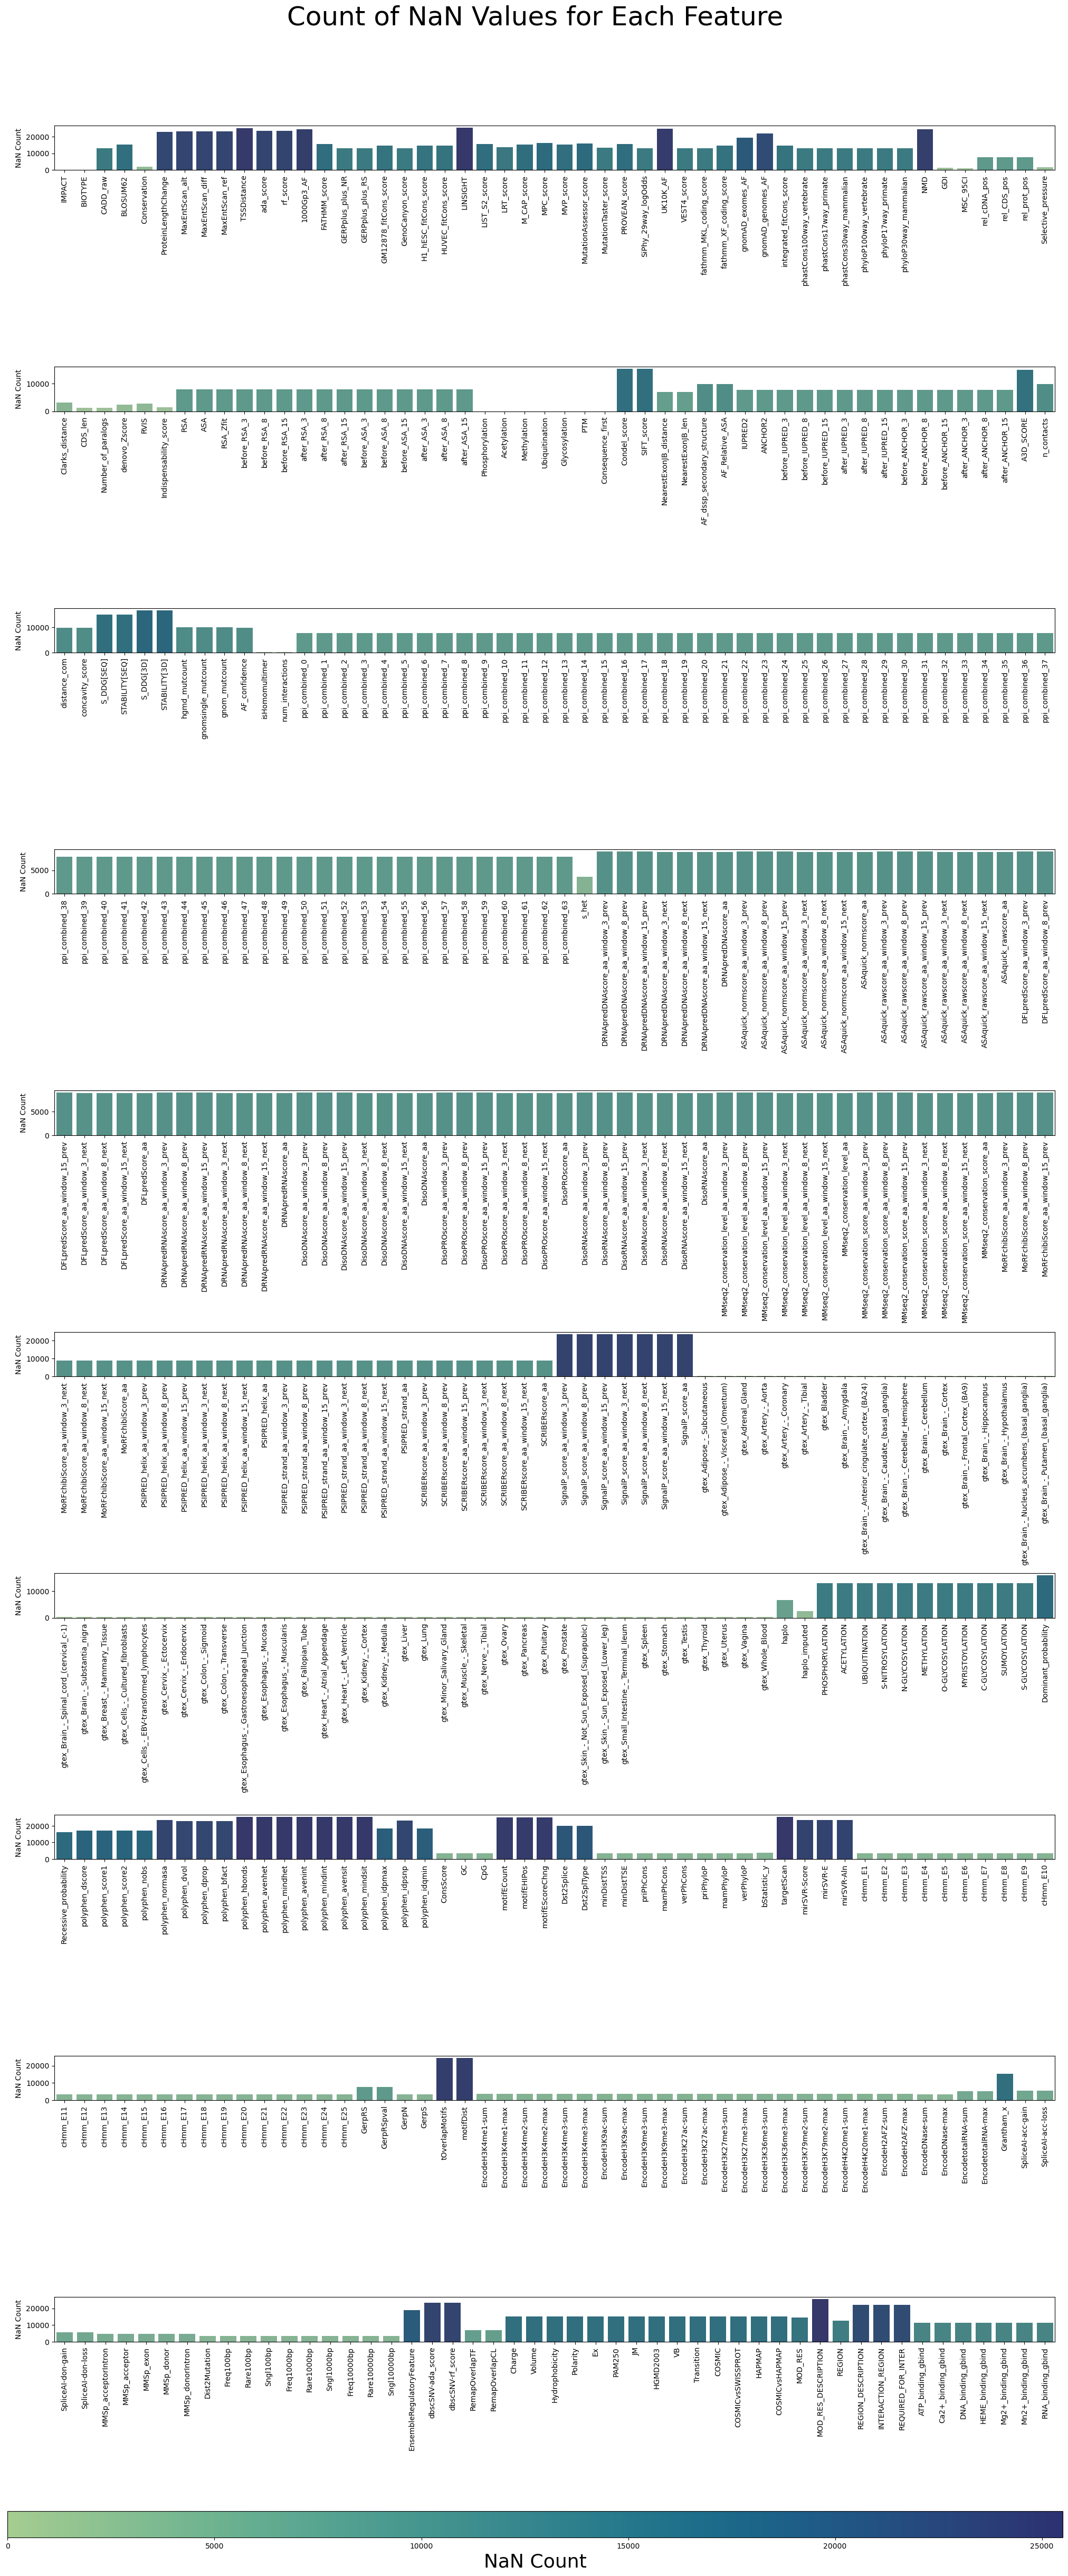

In [7]:
# I wanted to get an idea of how sparse the dataset was.
nan_counts = df.isna().sum()
nan_counts = nan_counts[1:]
cols_per_plot = 50
num_plots = (len(nan_counts) + cols_per_plot - 1) // cols_per_plot
fig, axes = plt.subplots(num_plots, 1, figsize=(20, 5 * num_plots))
if num_plots == 1:
    axes = [axes]

norm = plt.Normalize(nan_counts.min(), nan_counts.max())
sm = plt.cm.ScalarMappable(cmap=sns.color_palette("crest", as_cmap=True), norm=norm)
sm.set_array([])

for i in range(num_plots):
    start = i * cols_per_plot
    end = min((i + 1) * cols_per_plot, len(nan_counts))
    subset = nan_counts[start:end]
    colors = list(sm.to_rgba(subset.values))
    sns.barplot(x=subset.index, y=subset.values, ax=axes[i], palette=colors)
    axes[i].set_xticks(range(len(subset)))
    axes[i].set_xticklabels(subset.index, rotation=90)
    axes[i].set_ylabel('NaN Count')
    axes[i].set_xlabel('')

fig.suptitle('Count of NaN Values for Each Feature', fontsize=36)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  
cbar_ax = fig.add_axes([0, 0.02, 1, 0.01])  
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('NaN Count', fontsize=26)
plt.show()

## Encoding, Imputation, and Scaling

In [6]:
# Extract the features.
X = df.drop(columns=['ID']) 
print("Shape before encoding:", X.shape)

# Identify categorical and high-cardinality features.
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
high_card_features = [col for col in categorical_columns if X[col].nunique() > 10]
print("High-cardinality features:", high_card_features)

# Binary encoding on high-cardinality features and one-hot encoding on other categorical features.
encoder = BinaryEncoder(cols=high_card_features)
X_encoded = encoder.fit_transform(X)
X_encoded = pd.get_dummies(X_encoded, columns=[col for col in categorical_columns if col not in high_card_features])
print("Shape after encoding:", X_encoded.shape)

# Use simple imputer to fill missing values with mean and use standard scaler to scale the features.
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X_encoded)
X_scaled = scaler.fit_transform(X_imputed)
column_list = X_encoded.columns.tolist()
df_preprocessed = pd.DataFrame(X_scaled, columns=column_list)

Shape before encoding: (25546, 499)
High-cardinality features: ['Consequence_first', 'MOD_RES_DESCRIPTION', 'REGION_DESCRIPTION']
Shape after encoding: (25546, 539)


## Feature Selection Algorithms

In [8]:
# Init the dictionary for storing rankings from each algorithm.
ranks = {}
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks))

In [9]:
# Encode labels.
names = X_encoded.columns
le = LabelEncoder()
y = le.fit_transform(y_train['label'])
f, pval = f_regression(X_imputed, y, center=True)
ranks["Corr."] = rank_to_dict(f, names)

In [10]:
# Univariate linear regression.
cv_RFE = True
step = 5
if cv_RFE:
    n_folds = 7
    cv = StratifiedKFold(n_splits=n_folds)
else:
    nFeatures = 9  
f, pval = f_regression(X_imputed, y, center=True)
ranks["Corr."] = rank_to_dict(f, names)

In [11]:
# Linear Regression.
lr = LinearRegression() 
lr.fit(X_imputed, y)
ranks['Lin Reg'] = rank_to_dict(np.abs(lr.coef_), names)

In [12]:
# Ridge Regression.
ridge = Ridge(alpha=7)
ridge.fit(X_imputed, y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)

In [13]:
# Lasso Regression.
lasso = Lasso(alpha=.05)
lasso.fit(X_imputed, y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)

In [14]:
# Mutual Information.
mi = mutual_info_classif(X_imputed, y)
ranks["MI"] = rank_to_dict(mi, names)

In [15]:
# Random Forest Regression.
rf = RandomForestRegressor()
rf.fit(X_imputed, y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)

In [16]:
# Extra Trees Classification.
model = ExtraTreesClassifier()
model.fit(X_imputed, y)
ranks["RF Ext"] = rank_to_dict(model.feature_importances_, names)

In [ ]:
# ElasticNet Regression.
cv_RFE = True
if cv_RFE:
    n_folds = 7
    cv = KFold(n_splits=n_folds)  
else:
    nFeatures = 9 

elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5) 

if cv_RFE:
    rfe = RFECV(estimator=elasticnet, step=1, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
else:
    rfe = RFE(estimator=elasticnet, n_features_to_select=nFeatures, step=1)

X_scaled = StandardScaler().fit_transform(X_imputed)
rfe.fit(X_scaled, y)

print("features selected:", rfe.n_features_)
ranks["RFE: ElasticNet"] = rank_to_dict(rfe.ranking_, names, order=-1)

if cv_RFE:
    ranked = [f for r, f in sorted(zip(rfe.ranking_, names))]
    optFeats = ranked[:rfe.n_features_]
    print("number of selected features:", rfe.n_features_)

    plt.figure(figsize=(12, 5))
    plt.title("RFECV: ElasticNet")
    plt.xlabel("Number of features")
    plt.ylabel("Neg. MSE")

    x_values = rfe.cv_results_['n_features']
    y_values = -rfe.cv_results_['mean_test_score']
    plt.plot(x_values, y_values)
    closest_index = np.argmin(np.abs(x_values - rfe.n_features_))
    plt.plot(x_values[closest_index], y_values[closest_index], '*', markersize=12)
    plt.axvline(x_values[closest_index], linestyle=':', 
                label=f'Optimal ~{x_values[closest_index]} features')  
    plt.legend()
    plt.show()
    print("n_features values:", x_values)

best_score = -rfe.cv_results_['mean_test_score'].max()
total_ss = np.sum((y - np.mean(y))**2)
r_squared = 1 - (best_score * len(y)) / total_ss
print("R-squared:", r_squared)

In [ ]:
# Linear Regression.
cv_RFE = True
if cv_RFE:
    n_folds = 10
    cv = KFold(n_splits=n_folds)  
else:
    nFeatures = 9  
    
if cv_RFE:
    rfe = RFECV(lr, step=step, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1) 
else:
    rfe = RFE(lr, step=step, n_features_to_select=nFeatures, n_jobs=-1)

rfe.fit(X_imputed, y)
ranks["RFE: Lin"] = rank_to_dict(rfe.ranking_, names, order=-1)
if cv_RFE:
    ranked = [f for r, f in sorted(zip(rfe.ranking_, names))]
    optFeats = ranked[:rfe.n_features_]
    print("Optimal feature count: {} {}".format(rfe.n_features_, optFeats))

    plt.figure(figsize=(12, 5))
    plt.title("RFECV: Linear Regression")
    plt.xlabel("Number of features selected")
    plt.ylabel("CV score")
    plt.plot(range(1, len(rfe.cv_results_['mean_test_score']) + 1), rfe.cv_results_['mean_test_score'])
    plt.plot(rfe.n_features_, rfe.cv_results_['mean_test_score'][rfe.n_features_ - 1], '*', markersize=12)
    plt.axvline(rfe.n_features_, linestyle=':', label='Optimal {} features'.format(rfe.n_features_))
    plt.legend()
    plt.show()

In [19]:
# Linear Regression results.
print("n_features values:", rfe.cv_results_['n_features'])
print("Mean test scores:", rfe.cv_results_['mean_test_score'])

n_features values: [  1   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84
  89  94  99 104 109 114 119 124 129 134 139 144 149 154 159 164 169 174
 179 184 189 194 199 204 209 214 219 224 229 234 239 244 249 254 259 264
 269 274 279 284 289 294 299 304 309 314 319 324 329 334 339 344 349 354
 359 364 369 374 379 384 389 394 399 404 409 414 419 424 429 434 439 444
 449 454 459 464 469 474 479 484 489 494 499 504 509 514 519 524 529 534
 539]
Mean test scores: [-4.14308029e-01 -3.27447685e-01 -2.89321611e-01 -2.73229931e-01
 -5.52520521e+17 -2.38455362e+19 -1.86926876e+21 -2.86963664e+20
 -3.29193959e+18 -6.42335934e+20 -4.97354445e+20 -1.57072690e+21
 -1.83086047e+19 -1.64257753e+21 -4.28223484e+21 -3.07179025e+22
 -2.40600399e+21 -2.54476246e+21 -6.98478146e+22 -2.52671182e+22
 -1.08863313e+22 -4.52750402e+21 -4.11182923e+21 -2.60223048e+21
 -1.19808370e+21 -5.82190997e+21 -1.23693949e+21 -1.82624509e+21
 -1.89932902e+21 -8.46123815e+20 -4.80559032e+21 -1.21122412e+22

In [20]:
# Logistic Regression.
X_scaled = X_imputed
base_model = LogisticRegression(max_iter=100, solver='saga', penalty='l1')
model = OneVsRestClassifier(base_model)

def importance_getter(estimator):
    return np.mean([est.coef_ for est in estimator.estimators_], axis=0)
cv_RFE = True

if cv_RFE:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rfe = RFECV(model, step=step, cv=cv, scoring=make_scorer(accuracy_score), n_jobs=-1, importance_getter=importance_getter)
else:
    step = max(1, X_scaled.shape[1] // 1)
    nFeatures = 20 
    rfe = RFE(model, step=step, n_features_to_select=nFeatures, n_jobs=-1, importance_getter=importance_getter) 
    
rfe = rfe.fit(X_scaled, y)
ranks["RFE: Log"] = rank_to_dict(rfe.ranking_, names, order=-1)

/Users/benzenesea/mambaforge/envs/logofunc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benzenesea/mambaforge/envs/logofunc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benzenesea/mambaforge/envs/logofunc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benzenesea/mambaforge/envs/logofunc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benzenesea/mambaforge/envs/logofunc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did 

In [ ]:
# Logistic Regression results.
print("Keys in cv_results_:", rfe.cv_results_.keys())
print("Length of mean_test_score:", len(rfe.cv_results_['mean_test_score']))
print("n_features values:", rfe.cv_results_['n_features'])
print("Mean test scores:", rfe.cv_results_['mean_test_score'])

feature_numbers = rfe.cv_results_['n_features']
scores = rfe.cv_results_['mean_test_score']
feature_numbers = feature_numbers.tolist()
scores = scores.tolist()
zipped = sorted(zip(feature_numbers, scores))
feature_numbers, scores = zip(*zipped)

plt.figure(figsize=(12, 5))
plt.title("RFECV: Logistic Regression")
plt.xlabel("Number of Features Selected")
plt.ylabel("CV Score")
plt.plot(feature_numbers, scores, marker='o')
plt.xticks(feature_numbers)
plt.axvline(rfe.n_features_, linestyle=':', color='red', 
           label=f'Optimal {rfe.n_features_} Features')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Optimal feature count: {rfe.n_features_}")
for n, s in zip(feature_numbers, scores):
    print(f"{n:16} | {s:.4f}")

In [23]:
# Linear SVC.
C = 0.05  
w = 'balanced'
svc = SVC(kernel='linear', C=C, class_weight=w)
step = 5
n_folds = 5  
cv = StratifiedKFold(n_splits=n_folds)

if cv_RFE:
    rfe = RFECV(estimator=svc, step=step, cv=cv, scoring='f1_weighted', n_jobs=-1)  # Use all available cores
else:
    rfe = RFE(estimator=svc, step=step, n_features_to_select=nFeatures, n_jobs=-1)

rfe.fit(X_imputed, y)
ranks["RFE: SVC"] = rank_to_dict(rfe.ranking_, names, order=-1)

RFECV SVC optimal number of features: 69 ['1000Gp3_AF', 'AF_confidence', 'BIOTYPE_nonsense_mediated_decay', 'BIOTYPE_protein_coding', 'CADD_raw', 'ConsScore', 'Consequence_first_0', 'Consequence_first_4', 'DRNApredRNAscore_aa_window_15_prev', 'DRNApredRNAscore_aa_window_8_prev', 'Dominant_probability', 'EncodeH3K36me3-sum', 'IMPACT_HIGH', 'IMPACT_LOW', 'IMPACT_MODERATE', 'M_CAP_score', 'MoRFchibiScore_aa_window_15_next', 'MoRFchibiScore_aa_window_8_next', 'Number_of_paralogs', 'ProteinLengthChange', 'Rare10000bp', 'Recessive_probability', 'SpliceAI-acc-loss', 'SpliceAI-don-loss', 'UK10K_AF', 'VEST4_score', 'before_ASA_15', 'before_RSA_15', 'cHmm_E15', 'cHmm_E7', 'denovo_Zscore', 'gnomAD_exomes_AF', 'gnomAD_genomes_AF', 'gtex_Adipose_-_Subcutaneous', 'gtex_Artery_-_Aorta', 'gtex_Artery_-_Tibial', 'gtex_Bladder', 'gtex_Brain_-_Amygdala', 'gtex_Brain_-_Anterior_cingulate_cortex_(BA24)', 'gtex_Brain_-_Frontal_Cortex_(BA9)', 'gtex_Brain_-_Hippocampus', 'gtex_Brain_-_Hypothalamus', 'gtex_Bra

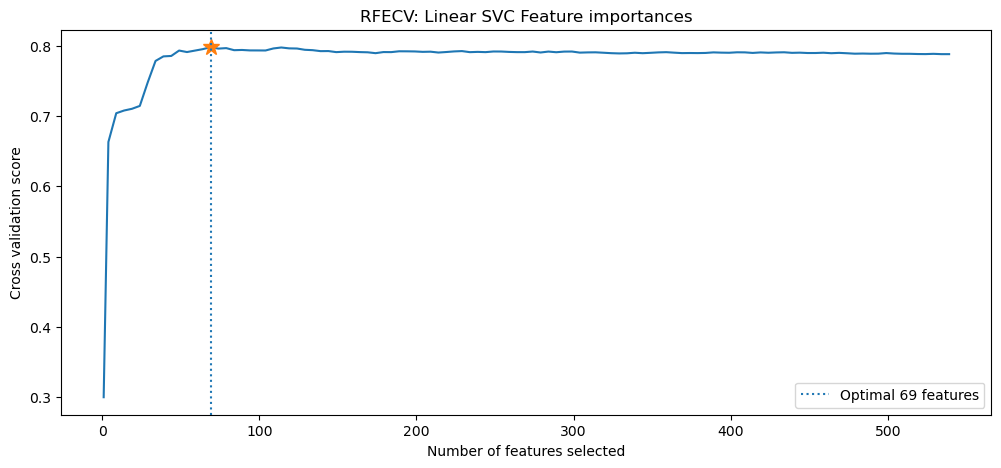

In [24]:
# Linear SVC results.
if cv_RFE:
    ranked = [f for r, f in sorted(zip(rfe.ranking_, names))]
    optFeats = ranked[:rfe.n_features_]
    print("RFECV SVC optimal number of features: {} {}".format(rfe.n_features_, optFeats))

    plt.figure(figsize=(12, 5))
    plt.title("RFECV: Linear SVC Feature importances")
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score")

    mean_test_scores = rfe.cv_results_['mean_test_score']
    plt.plot(rfe.cv_results_['n_features'], mean_test_scores)

    optimal_index = np.where(rfe.cv_results_['n_features'] == rfe.n_features_)[0][0]
    plt.plot(rfe.n_features_, mean_test_scores[optimal_index], '*', markersize=12)
    plt.axvline(rfe.n_features_, linestyle=':', label='Optimal {} features'.format(rfe.n_features_))
    plt.legend()
    plt.show()

In [25]:
# Random Forest Classification.
model = RandomForestClassifier(n_estimators=100, random_state=42)

if cv_RFE:
    rfe = RFECV(model, step=step, cv=cv, scoring=make_scorer(accuracy_score))
else:
    rfe = RFE(model, step=step, n_features_to_select=nFeatures)

rfe = rfe.fit(X_imputed, y)
ranks["RFE: RF"] = rank_to_dict(rfe.ranking_, names, order=-1)

RFECV Random Forest optimal number of features: 69 ['AF_Relative_ASA', 'AF_confidence', 'CADD_raw', 'CDS_len', 'Clarks_distance', 'Condel_score', 'ConsScore', 'Consequence_first_0', 'Consequence_first_4', 'Conservation', 'DisoPROscore_aa_window_15_prev', 'DisoPROscore_aa_window_8_prev', 'Dominant_probability', 'EncodeH3K4me1-sum', 'EncodeH3K9me3-sum', 'EncodetotalRNA-sum', 'GC', 'GDI', 'GerpRS', 'GerpS', 'IMPACT_HIGH', 'IMPACT_LOW', 'IMPACT_MODIFIER', 'Indispensability_score', 'LIST_S2_score', 'MMSp_exon', 'MPC_score', 'MSC_95CI', 'MVP_score', 'M_CAP_score', 'MutationAssessor_score', 'MutationTaster_score', 'NearestExonJB_distance', 'NearestExonJB_len', 'Number_of_paralogs', 'PROVEAN_score', 'RVIS', 'Recessive_probability', 'SCRIBERscore_aa_window_15_prev', 'SIFT_score', 'S_DDG[SEQ]', 'Selective_pressure', 'Sngl10000bp', 'SpliceAI-don-loss', 'VEST4_score', 'ada_score', 'after_IUPRED_3', 'after_IUPRED_8', 'before_IUPRED_8', 'denovo_Zscore', 'fathmm_MKL_coding_score', 'gnomAD_exomes_AF',

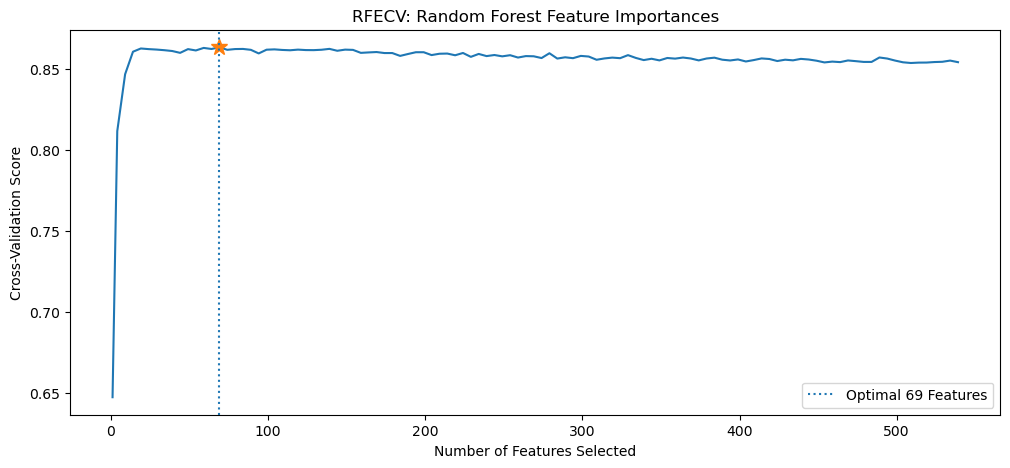

In [26]:
# Random Forest Classification results.
if cv_RFE:
    ranked = [f for r, f in sorted(zip(rfe.ranking_, names))]
    optFeats = ranked[:rfe.n_features_]
    print("RFECV Random Forest optimal number of features: {} {}".format(rfe.n_features_, optFeats))

    plt.figure(figsize=(12, 5))
    plt.title("RFECV: Random Forest Feature Importances")
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Cross-Validation Score")
    plt.plot(rfe.cv_results_['n_features'], rfe.cv_results_['mean_test_score'])

    optimal_index = np.where(rfe.cv_results_['n_features'] == rfe.n_features_)[0][0]
    plt.plot(rfe.n_features_, rfe.cv_results_['mean_test_score'][optimal_index], '*', markersize=12)
    plt.axvline(rfe.n_features_, linestyle=':', label='Optimal {} Features'.format(rfe.n_features_))
    plt.legend()
    plt.show()

### Export the rankings dictionary to CSV for future use:

In [70]:
def dict_csv(nested_dict, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Category', 'Name', 'Rank']) 
        for category, values in nested_dict.items():
            for name, rank in values.items():
                writer.writerow([category, name, rank])
dict_csv(ranks, 'ranks.csv')

In [10]:
def read_csv(filename):
    nested_dict = {}
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            category, name, rank = row
            if category not in nested_dict:
                nested_dict[category] = {}
            nested_dict[category][name] = float(rank)
    return nested_dict
loaded_dict = read_csv('ranks.csv')

### Calculate mean for the rankings and plot them:

In [ ]:
loaded_dict["Mean"] = {name: round(np.mean([loaded_dict[method][name] for method in loaded_dict.keys()]), 3) for name in names}
methods = sorted(loaded_dict.keys())
methods.append("Mean")

In [294]:
print(sorted(loaded_dict['Mean']))

['1000Gp3_AF', 'A3D_SCORE', 'ACETYLATION', 'AF_Relative_ASA', 'AF_confidence', 'AF_dssp_secondary_structure_-', 'AF_dssp_secondary_structure_B', 'AF_dssp_secondary_structure_E', 'AF_dssp_secondary_structure_G', 'AF_dssp_secondary_structure_H', 'AF_dssp_secondary_structure_I', 'AF_dssp_secondary_structure_S', 'AF_dssp_secondary_structure_T', 'ANCHOR2', 'ASA', 'ASAquick_normscore_aa', 'ASAquick_normscore_aa_window_15_next', 'ASAquick_normscore_aa_window_15_prev', 'ASAquick_normscore_aa_window_3_next', 'ASAquick_normscore_aa_window_3_prev', 'ASAquick_normscore_aa_window_8_next', 'ASAquick_normscore_aa_window_8_prev', 'ASAquick_rawscore_aa', 'ASAquick_rawscore_aa_window_15_next', 'ASAquick_rawscore_aa_window_15_prev', 'ASAquick_rawscore_aa_window_3_next', 'ASAquick_rawscore_aa_window_3_prev', 'ASAquick_rawscore_aa_window_8_next', 'ASAquick_rawscore_aa_window_8_prev', 'ATP_binding_gbind', 'Acetylation', 'BIOTYPE_lncRNA', 'BIOTYPE_nonsense_mediated_decay', 'BIOTYPE_promoter_flanking_region',

In [295]:
print(loaded_dict['Mean'])

{'CADD_raw': 0.388, 'BLOSUM62': 0.194, 'Conservation': 0.352, 'ProteinLengthChange': 0.247, 'MaxEntScan_alt': 0.243, 'MaxEntScan_diff': 0.323, 'MaxEntScan_ref': 0.191, 'TSSDistance': 0.212, 'ada_score': 0.289, 'rf_score': 0.337, '1000Gp3_AF': 0.381, 'FATHMM_score': 0.389, 'GERPplus_plus_NR': 0.352, 'GERPplus_plus_RS': 0.317, 'GM12878_fitCons_score': 0.307, 'GenoCanyon_score': 0.291, 'H1_hESC_fitCons_score': 0.265, 'HUVEC_fitCons_score': 0.3, 'LINSIGHT': 0.173, 'LIST_S2_score': 0.381, 'LRT_score': 0.318, 'M_CAP_score': 0.439, 'MPC_score': 0.423, 'MVP_score': 0.408, 'MutationAssessor_score': 0.378, 'MutationTaster_score': 0.403, 'PROVEAN_score': 0.369, 'SiPhy_29way_logOdds': 0.333, 'UK10K_AF': 0.395, 'VEST4_score': 0.616, 'fathmm_MKL_coding_score': 0.433, 'fathmm_XF_coding_score': 0.382, 'gnomAD_exomes_AF': 0.573, 'gnomAD_genomes_AF': 0.351, 'integrated_fitCons_score': 0.278, 'phastCons100way_vertebrate': 0.406, 'phastCons17way_primate': 0.387, 'phastCons30way_mammalian': 0.264, 'phyloP1

In [296]:
mean_dict = loaded_dict['Mean']

In [298]:
# Sort dict values in descending order.
sorted_mean_dict = dict(sorted(mean_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_mean_dict)

{'Consequence_first_0': 0.831, 'IMPACT_HIGH': 0.645, 'ConsScore': 0.641, 'VEST4_score': 0.616, 'verPhyloP': 0.592, 'gnomAD_exomes_AF': 0.573, 'IMPACT_LOW': 0.546, 'verPhCons': 0.536, 'IMPACT_MODIFIER': 0.481, 'mamPhyloP': 0.476, 'mamPhCons': 0.469, 'Dominant_probability': 0.467, 'phyloP100way_vertebrate': 0.443, 'M_CAP_score': 0.439, 'Consequence_first_4': 0.438, 'fathmm_MKL_coding_score': 0.433, 'GerpS': 0.431, 'MPC_score': 0.423, 'cHmm_E4': 0.421, 'cHmm_E15': 0.421, 'after_IUPRED_8': 0.418, 'IMPACT_MODERATE': 0.418, 'priPhCons': 0.413, 'denovo_Zscore': 0.411, 'Condel_score': 0.41, 'MVP_score': 0.408, 'phastCons100way_vertebrate': 0.406, 'after_IUPRED_15': 0.406, 'Recessive_probability': 0.405, 'MutationTaster_score': 0.403, 'Number_of_paralogs': 0.403, 'dbscSNV-rf_score': 0.399, 'BIOTYPE_protein_coding': 0.399, 'cHmm_E7': 0.396, 'UK10K_AF': 0.395, 'before_ANCHOR_15': 0.395, 'Rare10000bp': 0.395, 'AF_confidence': 0.394, 'ANCHOR2': 0.393, 'EncodeH3K36me3-sum': 0.391, 'SpliceAI-don-loss

In [300]:
# Save the dictionary to CSV.
csv_file = 'sorted_mean_dict.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Key', 'Value'])
    for key, value in sorted_mean_dict.items():
        writer.writerow([key, value])
print(f"Dictionary has been exported to {csv_file}")

Dictionary has been exported to sorted_mean_dict.csv


In [86]:
df_FS = pd.DataFrame(data=loaded_dict, index=pd.Index(names))
df_FS.sort_values(by='Mean', ascending=False, inplace=True)
df_FS.columns.name = "Method"
df_FS.index.name = "Feature"
df_FS.to_csv("feature_ranks.csv", float_format="%.3f")

## Plotting feature rankings by method

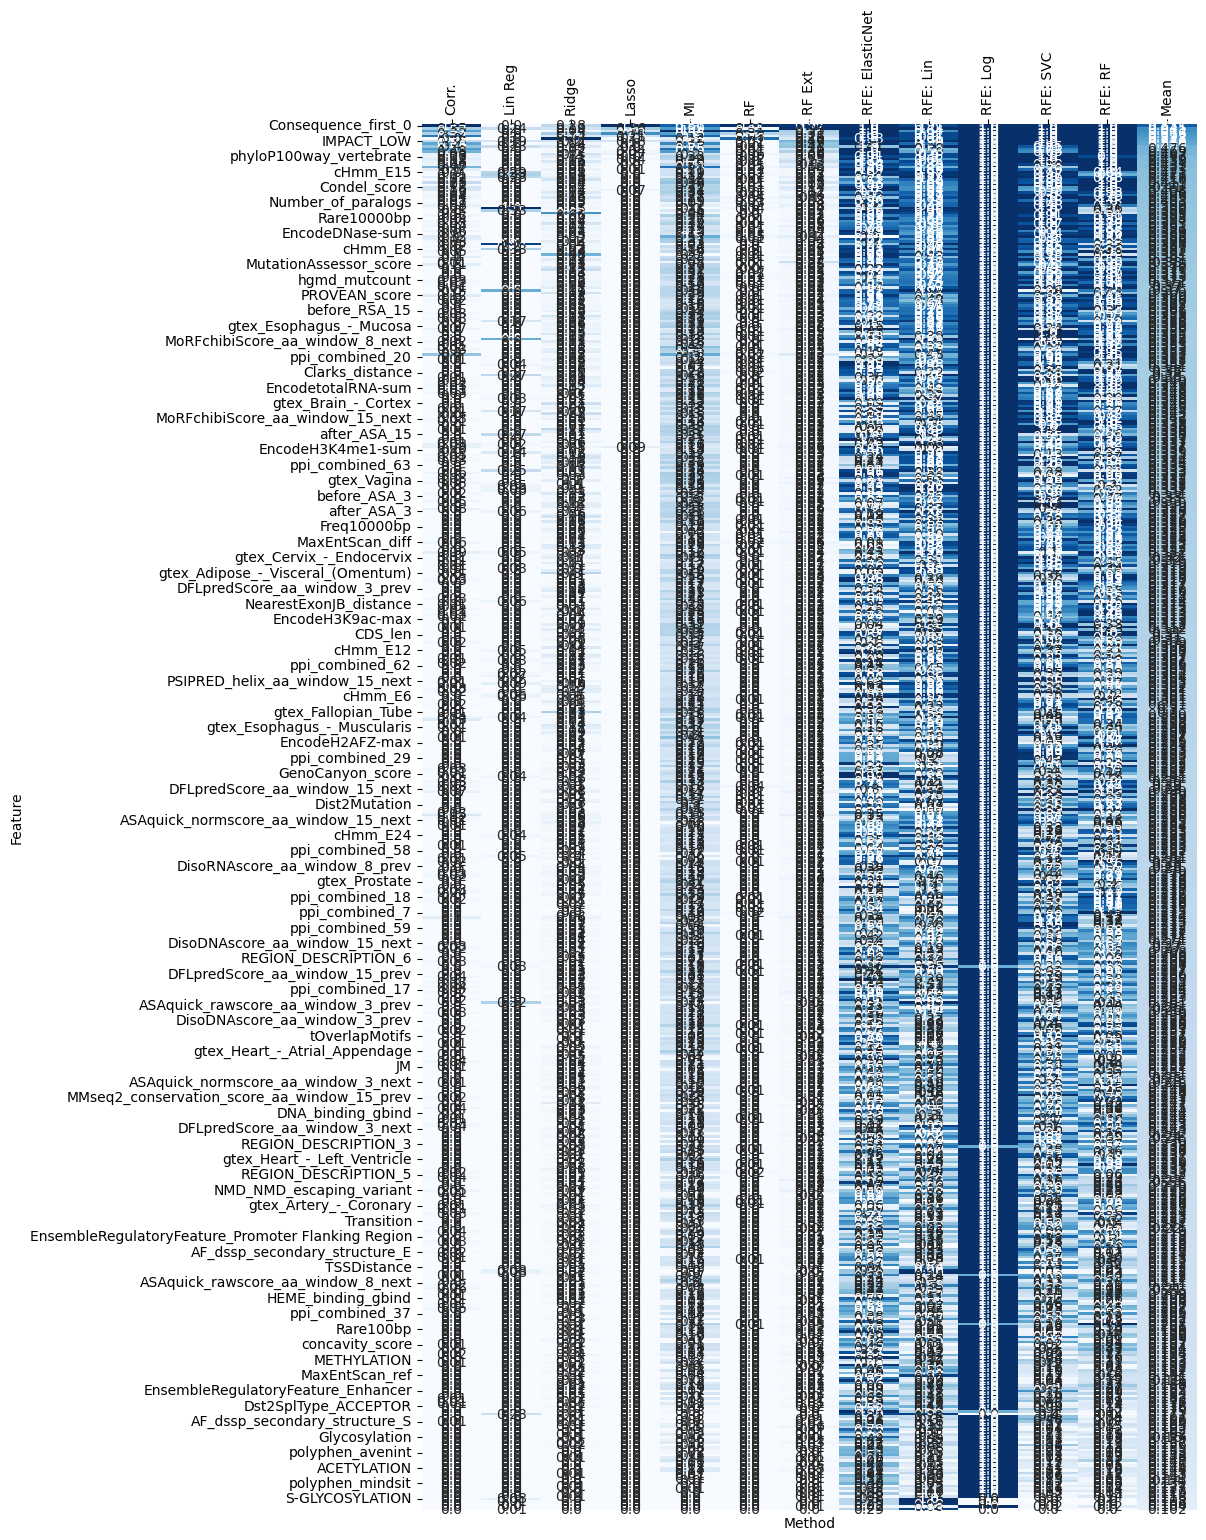

In [87]:
# Heatmap of feature ranks.
fig = plt.figure(figsize=(10, 18))
ax = fig.add_subplot(111)
sns.heatmap(df_FS, annot=True, cbar=False, ax=ax, fmt='', cmap='Blues')
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=90) 
fig.savefig("feature_ranks_heatmap.png")
plt.show() 

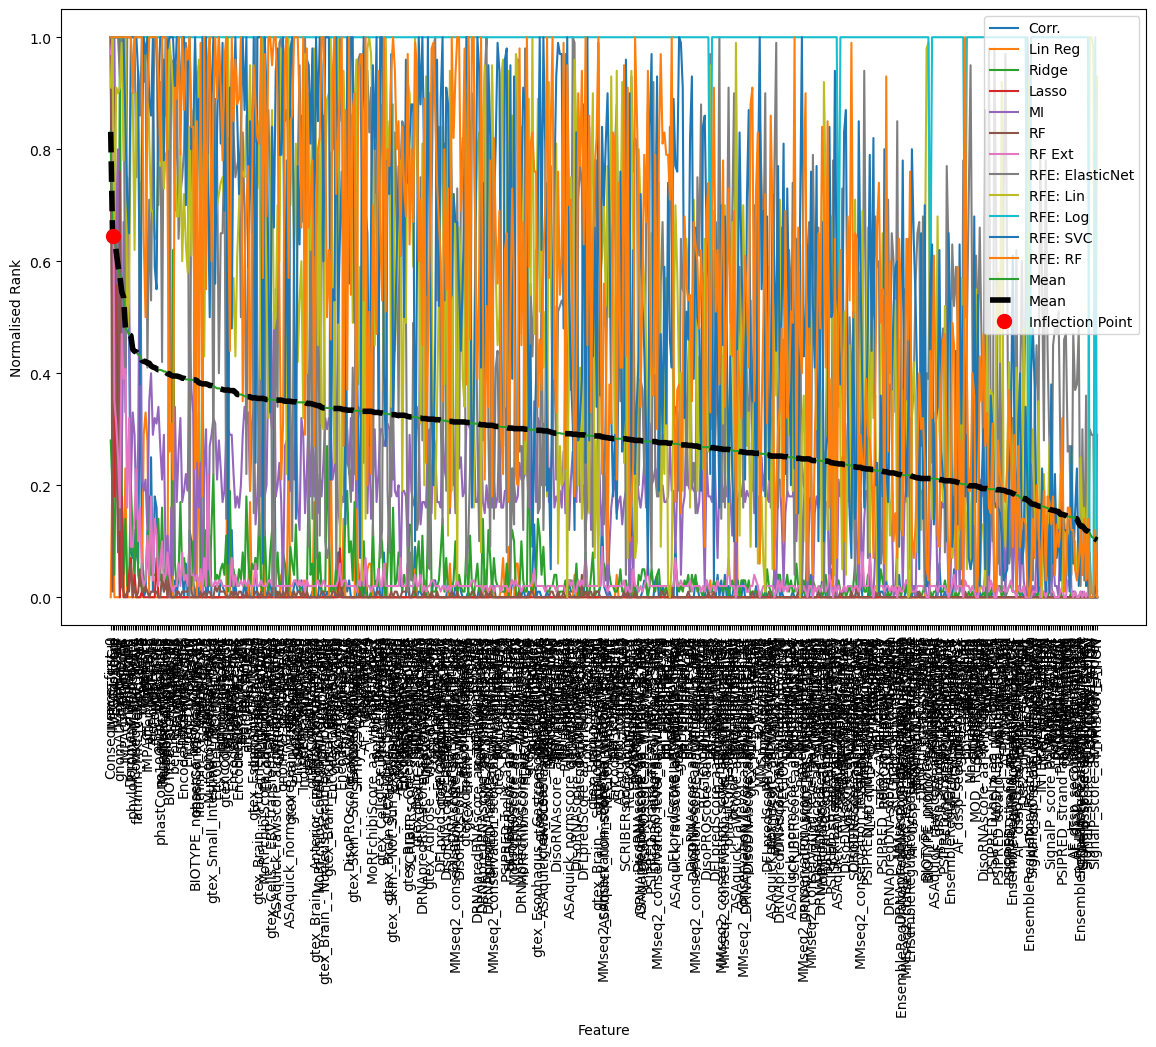

In [88]:
# Scree plot of feature ranks with inflection point.
def inflec_point(y):
    second_derivative = np.diff(np.diff(y))
    inflection_point = np.where(np.diff(np.sign(second_derivative)))[0][0] + 1
    return inflection_point

inflection_index = inflec_point(df_FS['Mean'].values)
inflection_feature = df_FS.index[inflection_index]
inflection_value = df_FS['Mean'].iloc[inflection_index]

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
df_FS.plot(ax=ax)
ax.plot(range(len(df_FS)), df_FS["Mean"], "k--", lw=4, label="Mean")
ax.plot(inflection_index, inflection_value, 'ro', markersize=10, label="Inflection Point")
xticks, xlabels = list(range(len(df_FS))), df_FS.index.tolist()
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation='vertical')
ax.set_ylabel("Normalised Rank")
plt.legend()
fig.savefig("feature_ranks_scree.png")
plt.show()

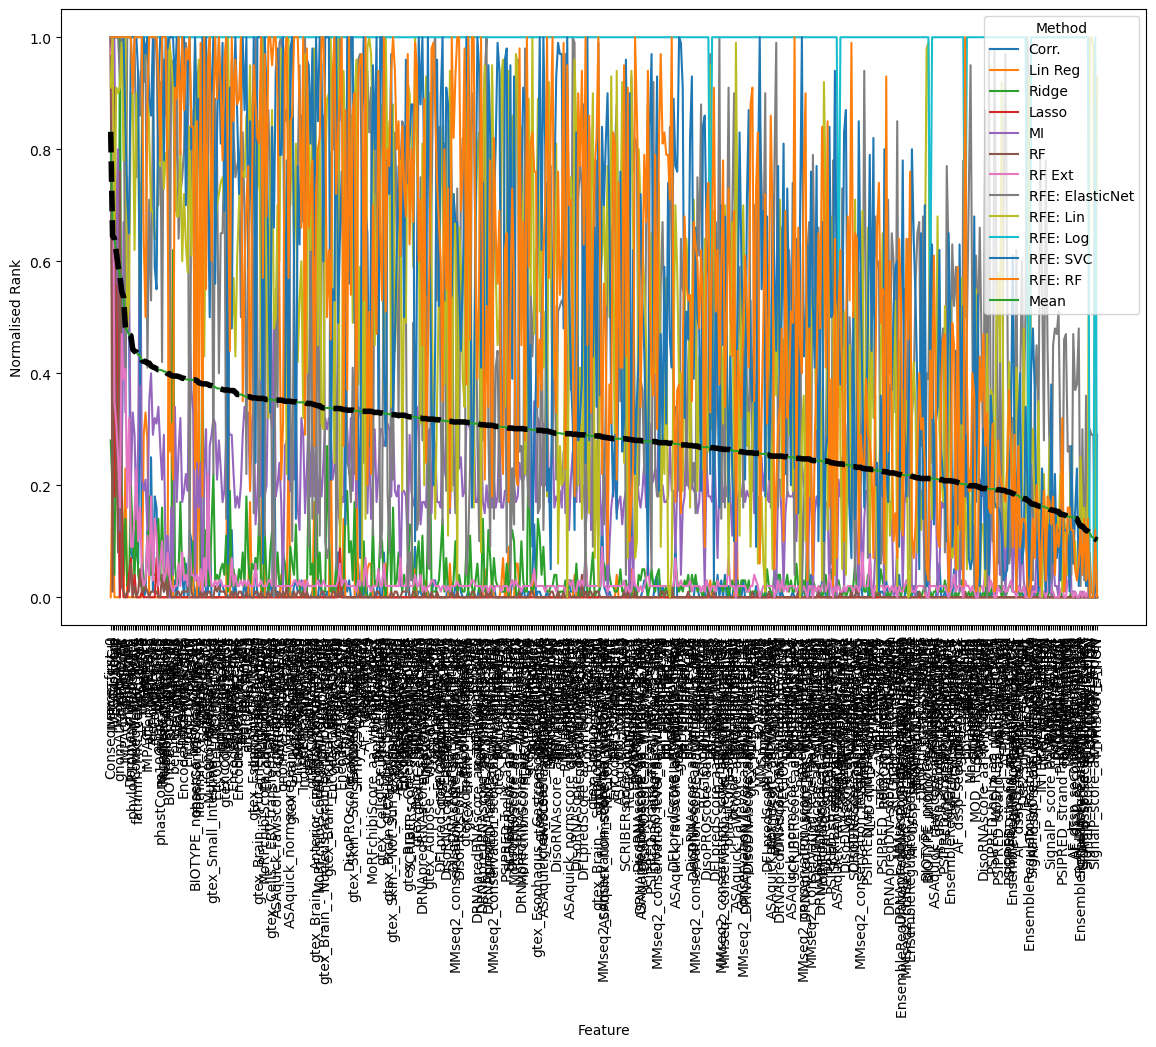

In [89]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
df_FS.plot(ax=ax)
ax.plot(range(len(df_FS)), df_FS["Mean"], "k--", lw=4, label="Mean")
xticks, xlabels = list(range(len(df_FS))), df_FS.index.tolist()
ax.set_xticks(xticks)
_ = ax.set_xticklabels(xlabels, rotation='vertical')
_ = ax.set_ylabel("Normalised Rank")
fig.savefig("feature_ranks_scree.png")

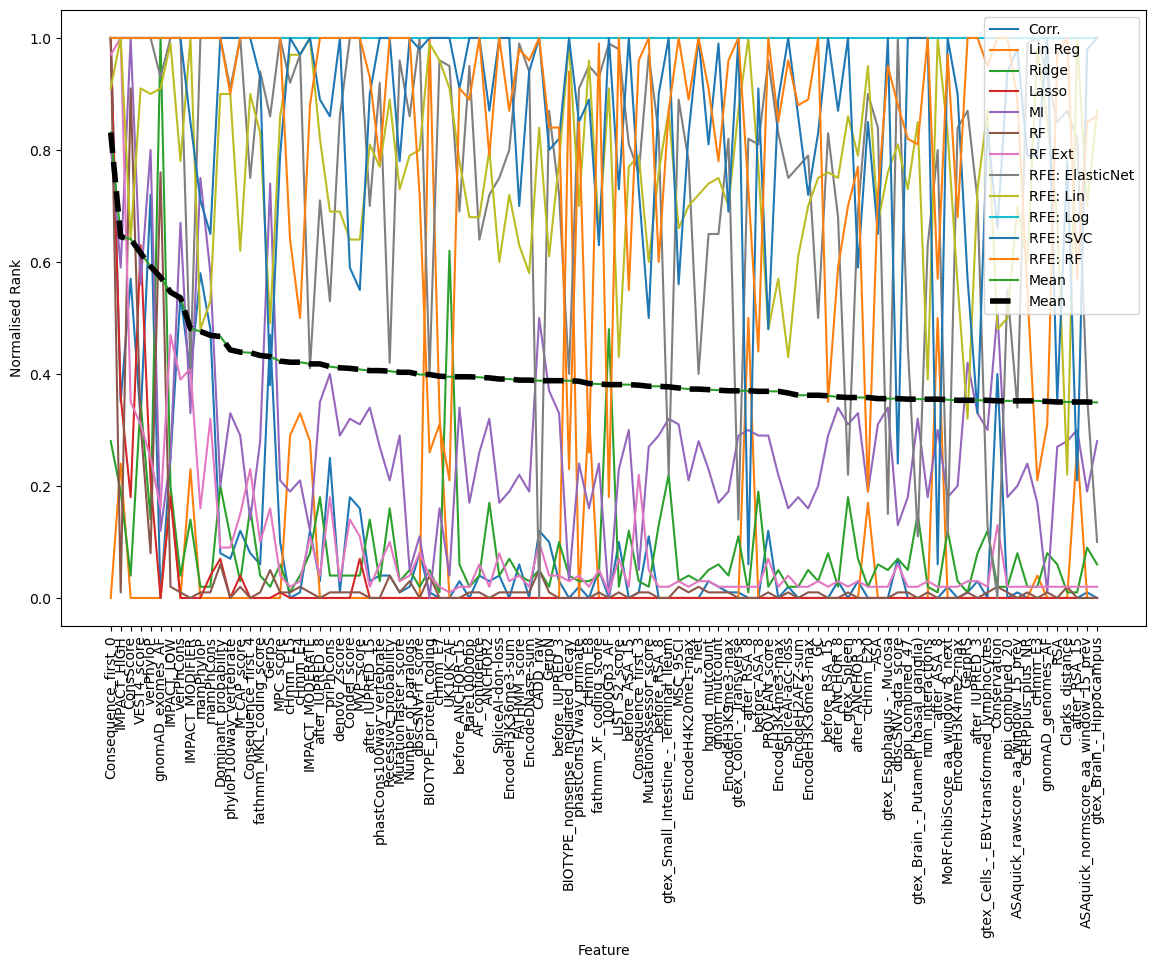

In [90]:
# Narrow the range to Top 50 features.
df_top50 = df_FS.head(100)
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
df_top50.plot(ax=ax)
ax.plot(range(len(df_top50)), df_top50["Mean"], "k--", lw=4, label="Mean")
xticks, xlabels = list(range(len(df_top50))), df_top50.index.tolist()
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation='vertical')
ax.set_ylabel("Normalised Rank")
ax.legend()
fig.savefig("feature_ranks_scree_top50.png")
plt.show()

## Visualizing distribution of mean and standard deviation values for feature rankings:

In [31]:
# Compute mean and standard deviation of feature ranks.
df_scores = pd.DataFrame(ranks)
feature_stats = pd.DataFrame({'Mean': df_scores.mean(axis=1), 'Std': df_scores.std(axis=1)})

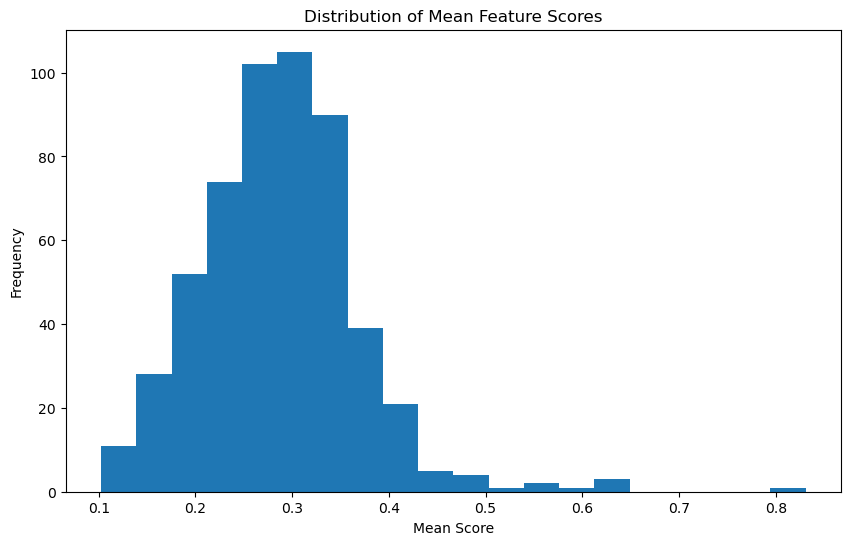

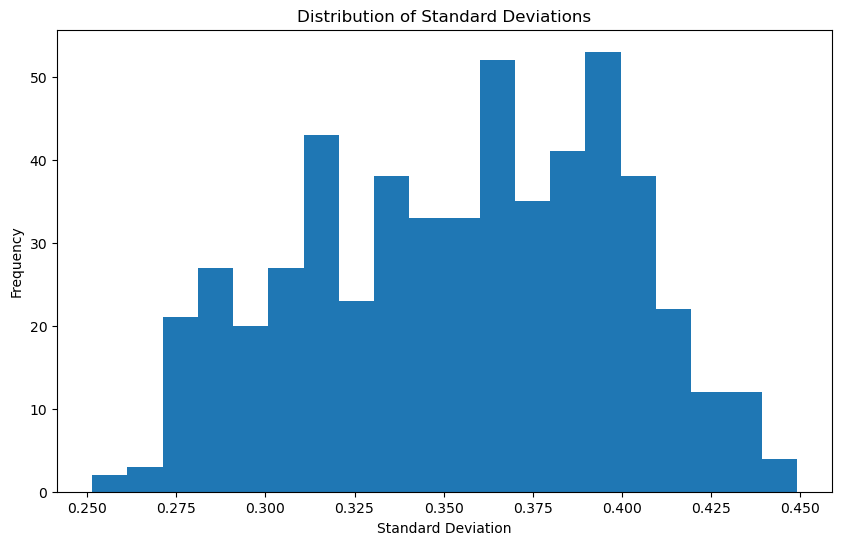

In [32]:
# Plotting distribution of means.
plt.figure(figsize=(10, 6))
plt.hist(feature_stats['Mean'], bins=20)
plt.xlabel('Mean Score')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Feature Scores')
plt.show()

# Plotting distribution of sttandard deviations.
plt.figure(figsize=(10, 6))
plt.hist(feature_stats['Std'], bins=20)
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Standard Deviations')
plt.show()